In [1]:
# TODO:
# Dont forget about normalized agent state
# Dont forget about put logits to loss, not probablility

In [1]:
!nvidia-smi

Wed Jun  1 20:33:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.89       Driver Version: 465.89       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   40C    P8     1W /  N/A |    532MiB /  4096MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import numpy as np

print(f'Cuda available: {torch.cuda.is_available()}')

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running on: {device}, Device count: {torch.cuda.device_count()}')

Cuda available: True
Running on: cuda, Device count: 1


### Init dataset

In [3]:
from nuscenes import NuScenes
from custom_prediction.helper import PredictHelper

In [4]:
# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = './dataset/'

nusc = NuScenes('v1.0-mini', dataroot=DATAROOT, verbose=False)

In [5]:
from nuscenes.eval.prediction.splits import get_prediction_challenge_split

train_samples = get_prediction_challenge_split("train", dataroot=DATAROOT)
valid_samples = get_prediction_challenge_split("train_val", dataroot=DATAROOT)

In [6]:
import matplotlib.pyplot as plt

def show_img(img, size=4):
    plt.figure(figsize=(size, size))
    plt.axis('off')
#     img_sorce = img *= 255
    plt.imshow(img)
    plt.show()

### Dataset loading

In [7]:
import numpy as np

NPY_DATAROOT = './npy_dataset/'

In [8]:
train_images = np.load(f'{NPY_DATAROOT}train/train_img.npy')
train_states = np.load(f'{NPY_DATAROOT}train/train_states.npy')
train_labels = np.load(f'{NPY_DATAROOT}train/train_labels.npy')

# train_images = np.load(f'{NPY_DATAROOT}train_img_small.npy')
# train_states = np.load(f'{NPY_DATAROOT}train_states_small.npy')
# train_labels = np.load(f'{NPY_DATAROOT}train_labels_small.npy')

In [9]:
len(train_images), len(train_states), len(train_labels)

(100, 100, 100)

In [10]:
valid_images = np.load(f'{NPY_DATAROOT}valid/valid_img.npy')
valid_states = np.load(f'{NPY_DATAROOT}valid/valid_states.npy')
valid_labels = np.load(f'{NPY_DATAROOT}valid/valid_labels.npy')

# valid_images = np.load(f'{NPY_DATAROOT}valid_img_small.npy')
# valid_states = np.load(f'{NPY_DATAROOT}valid_states_small.npy')
# valid_labels = np.load(f'{NPY_DATAROOT}valid_labels_small.npy')

In [11]:
len(valid_images), len(valid_states), len(valid_labels)

(100, 100, 100)

In [12]:
# Fix error dot : expected both vectors to have same dtype, but found Double and Float
# Because predictions from MTP in type float32

train_labels = train_labels.astype(np.float32)
valid_labels = valid_labels.astype(np.float32)

### Check data

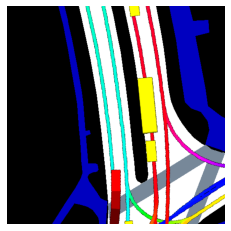

[ 0.34211713 -1.          0.5       ]

[-0.19719921  4.4419527  -0.18747053  9.426088   -0.17884889 13.900209
 -0.1102653  19.262684    0.28769872 24.559027    0.8526941  29.850317
  1.5770272  35.082508    2.3071277  40.355736    2.9427435  45.89043
  3.9777403  51.535393    5.021899   57.50441     6.026791   62.815197  ]


In [59]:
index_to_check = 85

img = valid_images[index_to_check]
img = img.reshape((500, 500, 3))

show_img(img)

print(train_states[index_to_check])
print()
print(train_labels[index_to_check])

In [14]:
def plot_path(trajectory):
    plt.scatter(trajectory[:, 1], -trajectory[:, 0], c='g', s=10)
    # Keep aspect ratio of axis
    plt.axis('equal')
    plt.show()

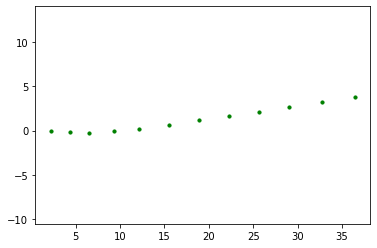

In [15]:
a = train_labels[index_to_check].reshape(12, 2)
plot_path(a)

### Clear everything before start

In [16]:
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

In [17]:
# free_gpu_cache()

### Train

In [18]:
# import wandb

# wandb.init(
#     project='MTP_1.0',
#     entity='techtoker',
#     config={    
#         "epoch": 32,
#         "batch_size": 32,
#         "num_modes": 4,
#         "lr":9e-5,
#         "notes": "second try"
#     })

# config = wandb.config

batch_size = 1
epoch = 32
num_modes = 4
lr = 3e-4

In [19]:
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from typing import List

class NuscenesDataset(Dataset):
    def __init__(self, features: List[str], states: List[str], labels: List[str]):
        
#         features = features.copy()
#         states = states.copy()
        
#         features = features.astype(np.float16)
    
#         # normalization
#         for i in range(len(features)):
#             features[i] = features[i] / 255.0
                    
#         max_velocity = 26.0
#         min_accel = -26.0
#         max_accel = 26.0
#         min_heading_cr = -1.5
#         max_heading_cr = 1.5
        
#         # normalization        
#         velocities = [state[0] / max_velocity for state in states]
#         accel = [(state[1] + abs(min_accel)) / (abs(min_accel) + max_accel) for state in states]
#         heading_cr = [(state[2] + abs(min_heading_cr)) / (abs(min_heading_cr) + max_heading_cr) for state in states]
        
#         for i in range(len(states)):
#             states[i] = np.array([velocities[i], accel[i], heading_cr[i]])
                
        self.features = features
        self.states = states
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index: int):
        image = self.features[index].reshape((500, 500, 3)) 
        
        #show_img(image)
        
        image = torch.Tensor(image).permute(2, 0, 1)
        
        agent_state_vector = torch.Tensor(self.states[index])
        ground_truth = self.labels[index].reshape((12, 2))

        # Convert to [batch_size, 1, 12, 2]
        # Because loss function need that format
        ground_truth = np.expand_dims(ground_truth, 0)

        return image, agent_state_vector, ground_truth

In [20]:
train_ds = NuscenesDataset(train_images, train_states, train_labels)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

validation_ds = NuscenesDataset(valid_images, valid_states, valid_labels)
validation_dl = DataLoader(train_ds, batch_size=batch_size * 2)

In [21]:
image, state, ground_truth = next(iter(train_dl))

print(image.size())
print(state.size())
print(ground_truth.size())

torch.Size([1, 3, 500, 500])
torch.Size([1, 3])
torch.Size([1, 1, 12, 2])


In [22]:
print(torch.min(image[0]), torch.max(image[0]))
print(state[0])

tensor(0.) tensor(255.)
tensor([0.2320, 0.5002, 0.5000])


In [23]:
img = image[0].permute(1, 2, 0).numpy()#.astype(np.float64)

In [24]:
img.shape

(500, 500, 3)

In [25]:
# for img in image:
#     test = img.permute(1, 2, 0).numpy()
    
#     for t1 in test:
#         for t2 in t1:
#             print(t2)
        
#     print()

In [25]:
# show_img(img.astype('uint8'))

In [25]:
velocities = [state[0] for state in train_states]
accel = [state[1] for state in train_states]
heading_cr = [state[2] for state in train_states]

print(min(velocities), max(velocities))
print(min(accel), max(accel))
print(min(heading_cr), max(heading_cr))

0.0 0.40697304104780024
-1.0 0.5838072193507226
0.47236136331809875 0.5378376051220178


In [27]:
# Output has 50 entries.
# The first 24 are x,y coordinates (in the agent frame) over the next 6 seconds at 2 Hz for the first mode.
# The second 24 are the x,y coordinates for the second mode.
# The last 2 are the logits of the mode probabilities
# mtp(image, state)

In [26]:
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP, MTPLoss

backbone = ResNetBackbone('resnet50')
model = MTP(backbone, num_modes=num_modes)
model = torch.nn.DataParallel(model)

model.load_state_dict(torch.load('./models/MTP_m4_e25_3.87.pth'))
model = model.to(device)

loss_function = MTPLoss(num_modes)
model

DataParallel(
  (module): MTP(
    (backbone): ResNetBackbone(
      (backbone): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

In [27]:
from torch.optim import Adam

# Pass to optimizer only params with requires_grad
params_to_update = []

for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

In [28]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, StepLR, ReduceLROnPlateau

optimizer = Adam(params_to_update, lr=lr, weight_decay=5e-4)
#scheduler_exp = ExponentialLR(optimizer, gamma=0.9)
scheduler_exp = StepLR(optimizer, step_size=5, gamma=0.9)

scheduler_onPlateau = ReduceLROnPlateau(optimizer, 'min')

In [29]:
import os

# Create folder for all models
dir = os.path.join('./models')
if not os.path.exists(dir):
    os.mkdir(dir)

In [30]:
import nuscenes.eval.prediction.metrics as metrics
from collections import defaultdict
from typing import List, Dict, Any


def GetPrediction(model, instance_token, sample_token, img, state):

    img = img.unsqueeze(0).to(device)
    state = state.unsqueeze(0).to(device)

    predict = model(img, state)
    predict = predict[0]

    trajectories_set = predict[:len(predict) - config.num_modes]
    trajectories_set = trajectories_set.reshape(config.num_modes, 12, 2)
        
    mode_probabilities = predict[-config.num_modes:]

    sorted_logits_indexes = mode_probabilities.argsort(descending=True)
    sorted_trajectories = trajectories_set[sorted_logits_indexes]
    
    mode_probabilities = mode_probabilities.cpu().detach().numpy()
    sorted_trajectories = sorted_trajectories.cpu().detach().numpy()
    
    top_trajectories = sorted_trajectories[:10]
    top_probabilities = mode_probabilities[:10]
    
    # Prediction contains more than 25 modes. 
    prediction = metrics.Prediction(instance_token, sample_token, top_trajectories, top_probabilities)

    return prediction


def GetMetrics(model, valid_ds, valid_samples):
    
    # Define metrics function and container
    metric_functions = [metrics.MinFDEK([1, 5], aggregators=[metrics.RowMean()]),
                        metrics.MinADEK([1, 5, 10], aggregators=[metrics.RowMean()]),
                        metrics.MissRateTopK([5, 10], tolerance=2, aggregators=[metrics.RowMean()])]

    num_predictions = len(valid_ds) # Amount of prediction rows (equals of len of validation)
    metrics_container = {metric.name: np.zeros((num_predictions, metric.shape)) for metric in metric_functions}
    
    # Prediction loop
    for idx in tqdm(range(len(valid_ds))):
        feature, state, ground_truth = valid_ds[idx]
        instance_tkn, sample_tkn = valid_samples[idx].split("_")
                        
        # Make prediction
        prediction = GetPrediction(model, instance_tkn, sample_tkn, feature, state)
        
        # Get ground_truth
        gt = ground_truth.reshape((12, 2))

        # Calculate metrics
        for metric in metric_functions:
            metrics_container[metric.name][idx] = metric(gt, prediction)
    
    # Metrics aggregations
    aggregations: Dict[str, Dict[str, List[float]]] = defaultdict(dict)

    for metric in metric_functions:
        for agg in metric.aggregators:
            aggregations[metric.name][agg.name] = agg(metrics_container[metric.name])

    return aggregations

In [31]:
from tqdm import tqdm
import time

def loss_batch(model, loss_func, img, state_vec, ground_truth, opt=None):
    img = img.to(device)
    state_vec = state_vec.to(device)
    ground_truth = ground_truth.to(device)
        
    predicted_logits = model(img, state_vec)
    loss = loss_func(predicted_logits, ground_truth)

    # For validation optimizer is None, thus we dont perform backprop
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    # Return losses and amount of items
    #print(f"{loss.item()}; {len(img)}")
    return loss.item(), len(img)


def train_step(model, train_dl, loss_func, opt):
    model.train()

    losses = []
    nums = []
    for img, state_vec, gt in tqdm(train_dl):
        loss, num = loss_batch(model, loss_func, img, state_vec, gt, opt)
        losses.append(loss)
        nums.append(num)
        
    # Calculate train loss
    train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    return train_loss


def validation_step(model, valid_dl, loss_func):
    tqdm.write("Validation step")
    time.sleep(0.5)
    
    model.eval()

    with torch.no_grad():
        losses = []
        nums = []
        for img, state_vec, gt in tqdm(valid_dl):
            loss, num = loss_batch(model, loss_func, img, state_vec, gt)
            losses.append(loss)
            nums.append(num)
        
        # Calculate validation loss
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        scheduler_exp.step()
        scheduler_onPlateau.step(val_loss)
        
    return val_loss


def log_metrics(model, valid_ds, valid_samples, start_epoch_time, best_loss, train_loss, val_loss):

    # Calculate metrics on validation set
    tqdm.write("Calculate metrics:")
    time.sleep(0.5)
    
#     metricsRes = GetMetrics(model, valid_ds, valid_samples)
    
#     minFDE_1 = metricsRes['MinFDEK']['RowMean'][0]
#     minFDE_5 = metricsRes['MinFDEK']['RowMean'][1]
#     minADEK_1 = metricsRes['MinADEK']['RowMean'][0]
#     minADEK_5 = metricsRes['MinADEK']['RowMean'][1]
#     minADEK_10 = metricsRes['MinADEK']['RowMean'][2]
#     missRateTopK2_5 = metricsRes['MissRateTopK_2']['RowMean'][0]
#     missRateTopK2_10 = metricsRes['MissRateTopK_2']['RowMean'][1]    

#     wandb.log({'Train loss': train_loss,
#                'Val loss': val_loss,
#                'Learning_rate': scheduler_exp.get_last_lr()[0],
#                'minFDE_1': minFDE_1,
#                'minFDE_5': minFDE_5,
#                'min_ADEK_1': minADEK_1,
#                'minADEK_5': minADEK_5,
#                'minADEK_10': minADEK_10,
#                'missRateTopK2_5':missRateTopK2_5,
#                'missRateTopK2_10':missRateTopK2_10
#               })
        
    print(f"Epoch {current_epoch + 1}; Train loss: {train_loss:0.2f}; Val loss: {val_loss:0.2f}; Best VL: {best_loss:0.2f}; Time: {(time.time() - start_epoch_time):0.2f} sec;")

In [32]:
import copy

current_epoch = 0
best_model_wts = copy.deepcopy(model.state_dict())

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, valid_ds, valid_samples):
    global current_epoch
    global best_model_wts
    
    best_loss = 999.0

    for epoch in range(epochs):
        start_epoch_time = time.time()
        tqdm.write('-' * 30)
        tqdm.write(f'Epoch: {epoch + 1}/{epochs}')
        time.sleep(0.5)
        
        train_loss = train_step(model, train_dl, loss_func, opt)        
        val_loss = validation_step(model, valid_dl, loss_func)  
        
        # deep copy the model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        log_metrics(model, valid_ds, valid_samples, start_epoch_time, best_loss, train_loss, val_loss)
            
        torch.save(copy.deepcopy(model.state_dict()), f'./Models/norm_MTP_m4_e{current_epoch}_{best_loss:0.2f}.pth')
        current_epoch += 1

In [33]:
fit(epoch, model, loss_function, optimizer, train_dl, validation_dl, validation_ds, valid_samples)

------------------------------
Epoch: 1/32


  0%|          | 0/100 [17:07<?, ?it/s]


KeyboardInterrupt: 

In [47]:
# optimizer.param_groups[0]['lr'] = 1e-5
# scheduler_exp = StepLR(optimizer, step_size=4, gamma=0.9)